In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Clustering, Initializers
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from functools import partial

2025-04-11 14:37:39.494465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 14:37:39.511601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 14:37:39.517004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1744375060.928910 3009618 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744375060.973034 3009618 cuda_executor.cc:1015] succ

## learnMSA tree demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

### Ungapped alignment

In [2]:
name = "3_200"
suffix = "_short"

# unaligned sequences
train_filename = f"../trees/alisim/{name}{suffix}.unaligned.fa"
# reference alignment of all sequences
ref_filename = f"../trees/alisim/{name}{suffix}.fa"
# tree used to generate the sequences
tree_filename = f"../trees/treegen/trees/{name}.nwk"

# number of distinct pHMMs
num_models = 5

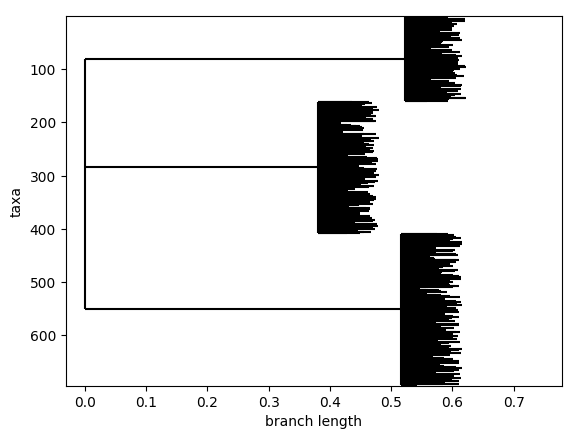

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

Falsely clustered sequences can lead to poor alignments. We'll have to account for that.

Problem: How to do that without computing emissions and transitions w.r.t. all models?

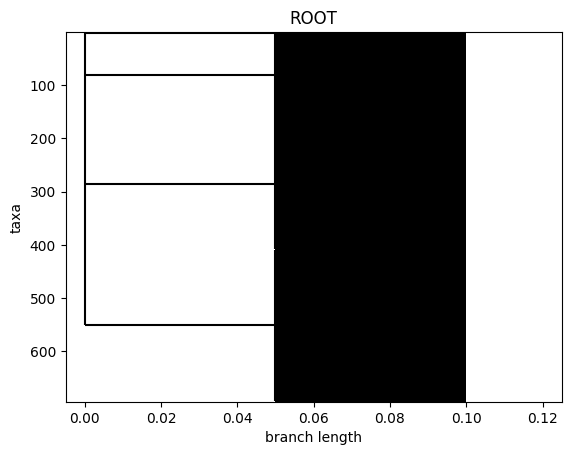

In [4]:
# compute a clustering from the unaligned sequences and a rough initial tree with short branches
clustering : pd.DataFrame = Clustering.compute_clustering(train_filename, cluster_seq_id=0.01, linear=False)
tree_handler = Clustering.cluster_tree(clustering, branch_length=0.05)
tree_handler.draw(no_labels=True)

In [5]:
# compute cluster precision
true_cluster_indices = true_tree.get_parent_indices_by_height(0)
cluster_indices = tree_handler.get_parent_indices_by_height(0)

true_positives = 0
positives = 0   
trues = 0   

leaf_names = tree_handler.node_names[:tree_handler.num_leaves]
for i,u_name in enumerate(leaf_names):
    for v_name in leaf_names[i+1:]:
        u = tree_handler.nodes[u_name]
        v = tree_handler.nodes[v_name]
        tu = true_tree.nodes[u_name]
        tv = true_tree.nodes[v_name]
        positives += int(u.parent == v.parent)
        trues += int(tu.parent == tv.parent)
        true_positives += int(u.parent == v.parent and tu.parent == tv.parent)

print("Cluster precision:", true_positives/positives)
print("Cluster recall:", true_positives/trues)
print("True number of clusters: ", true_tree.num_anc-1)
print("Predicted number of clusters: ", tree_handler.num_anc-1)

Cluster precision: 1.0
Cluster recall: 0.9970631249777059
True number of clusters:  3
Predicted number of clusters:  4


In [6]:
def encoder_weight_extractor(encoder_model : tf.keras.Model):
   K = -3.0 # default value if no kernel is found
   num_models = 1
   for layer in encoder_model.layers:
      if layer.name.startswith("anc_probs_layer"):
         K = layer.time_kernel.numpy()
         num_models = layer.num_models
   return [Initializers.ConstantInitializer(K)] + Initializers.make_LG_init(num_models)

In [7]:
surgery_runs = 3

out_filename = "test/data/interactive_alignment_tree.fasta"
with SequenceDataset(train_filename, fmt="fasta") as data:
    config = Configuration.make_default(num_models, 
                                        tree_handler=tree_handler,
                                        tree_loss_weight=1./data.num_seq,
                                        use_tree_transitioner=False)
    
    config["max_surgery_runs"] = surgery_runs
    config["len_mul"] = 1.0 if surgery_runs == 1 else 0.8
    config["epochs"] = [20, 10, 20]

    # making these smaller than 50%, the default, is required to account for
    # insertions in smaller clusters or deletions in larger clusters
    # config["surgery_ins"] = 0.8
    # config["surgery_del"] = 0.2

    # slower learning rate needed because of cluster perturbation?
    config["learning_rate"] = 0.05

    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    config["encoder_weight_extractor"] = encoder_weight_extractor
    initial_model_length_callback = partial(Align.get_initial_model_lengths, random=False)
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        verbose=True,
                                        align_insertions=True,
                                        A2M_output=False) #required to sum fastSP

Training of 5 models on file 3_200_short.unaligned.fa
Configuration: 
{
num_models : 5
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alp

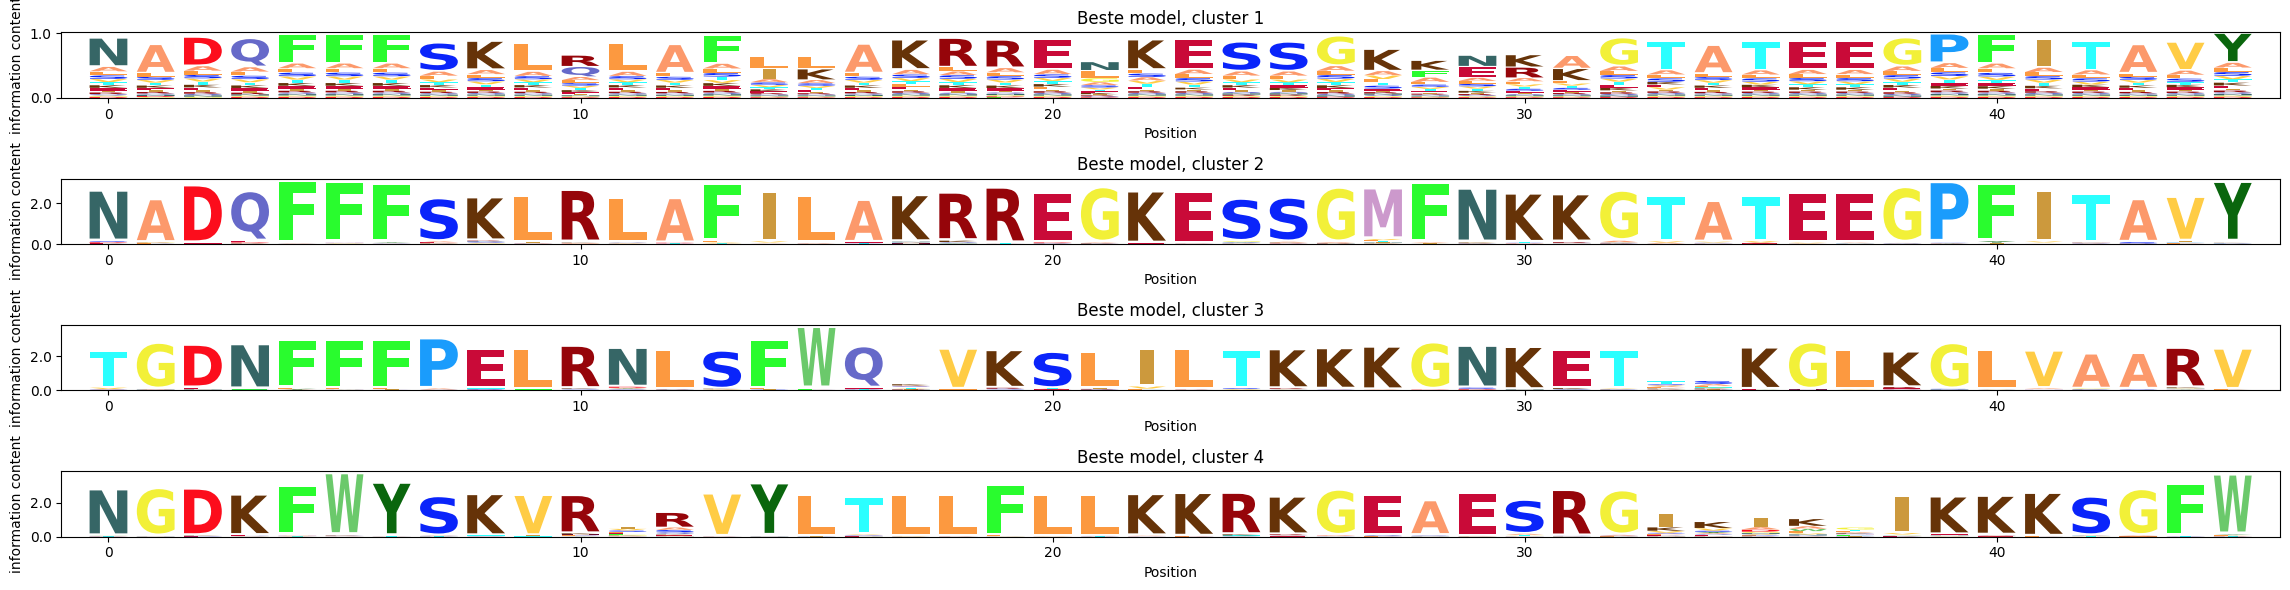

In [8]:
num_clust = tree_handler.num_anc-1
fig, axes = plt.subplots(num_clust, 1, figsize=(10, 5))
for i in range(num_clust):
    ax = axes[i]
    ax.set_title(f"Beste model, cluster {i+1}")
    ax.set_xlabel("Position")
    ax.set_ylabel("Information content")
    Visualize.plot_logo(alignment_model, alignment_model.best_model, ax, cluster_index=i)
plt.tight_layout()

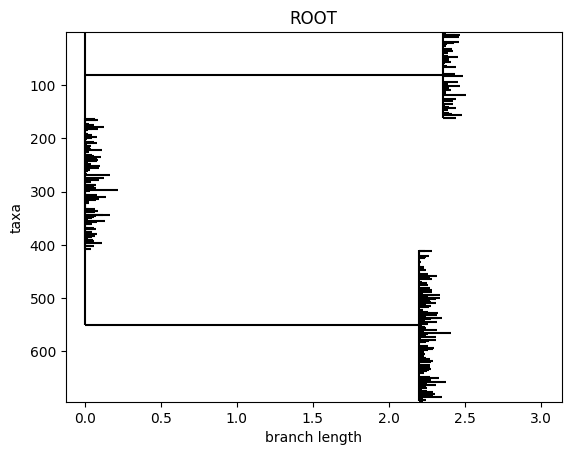

In [15]:
# plot the tree after training
# this requires to get both the branch lengths of the tree emitter for the ancestral past of the tree
# as well as the lengths of all leaf branches from the ancestral probability layer

# ancestral part
tree_emitter = alignment_model.msa_hmm_layer.cell.emitter[0]
branch_lengths = tree_emitter.get_branch_lengths().numpy()
branch_lengths = branch_lengths[:, alignment_model.best_model]
branch_lengths = branch_lengths[:, np.newaxis]

# leaf part
anc_prob_layer = alignment_model.encoder_model.layers[-3]
leaf_branch_lengths = anc_prob_layer.make_times().numpy()
leaf_branch_lengths = leaf_branch_lengths[:,alignment_model.best_model]
leaf_branch_lengths = leaf_branch_lengths[:,np.newaxis]

branch_lengths = np.concatenate((leaf_branch_lengths, branch_lengths), axis=0)

tree_emitter.tree_handler.set_branch_lengths(branch_lengths)
tree_emitter.tree_handler.draw(no_labels=True)

In [16]:
!java -jar ~/src/FastSP/FastSP.jar -r {ref_filename} -e test/data/interactive_alignment_tree.fasta

Reference alignment: /home/felix/src/learnMSA/../trees/alisim/3_200_short.fa ...
Estimated alignment: /home/felix/src/learnMSA/test/data/interactive_alignment_tree.fasta ...
MaxLenNoGap= 69, NumSeq= 694, LenRef= 716, LenEst= 192, Cells= 630152
computing ...
Number of shared homologies: 5224779
Number of homologies in the reference alignment: 8491918
Number of homologies in the estimated alignment: 9610416
Number of correctly aligned columns: 2
Number of aligned columns in ref. alignment: 65
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 642 0
Number of aligned columns in est. alignment: 145
Number of singleton and (uncollapsed) insertion columns in est. alignment: 47 0
SP-Score 0.6152648906878281
Modeler 0.5436579436311602
SPFN 0.3847351093121719
SPFP 0.45634205636883984
Compression (naive) 0.2681564245810056
Compression 0.27157001414427157
TC 0.03076923076923077
Time to compute (seconds): 0.061


In [18]:
#compute the cluster SP-scores
cluster_ids = true_tree.get_parent_indices_by_height(0)-true_tree.num_leaves
num_clust = np.max(cluster_ids)+1

cluster_ref_seqs = []
cluster_pred_seqs = []
for j in range(num_clust):
    cluster_ref_seqs.append([])
    cluster_pred_seqs.append([])

ref_data = SequenceDataset(ref_filename)
pred_data = SequenceDataset(out_filename)

for i,j in enumerate(cluster_ids):
    ref_seq = ref_data.get_standardized_seq(i, remove_gaps=False)
    pred_seq = pred_data.get_standardized_seq(i, remove_gaps=False)
    header = ref_data.get_header(i)
    assert header == pred_data.get_header(i)
    cluster_ref_seqs[j].append((header, ref_seq))
    cluster_pred_seqs[j].append((header, pred_seq))

ref_data.close()
pred_data.close()

for j in range(num_clust):

    cluster_ref_file_name = f"tmp/{j}_ref"
    with open(cluster_ref_file_name, "w") as cluster_ref_file:
        for header, seq in cluster_ref_seqs[j]:
            cluster_ref_file.write(">"+header+"\n")
            cluster_ref_file.write(seq+"\n")

    cluster_pred_file_name = f"tmp/{j}_pred"
    with open(cluster_pred_file_name, "w") as cluster_pred_file:
        for header, seq in cluster_pred_seqs[j]:
            cluster_pred_file.write(">"+header+"\n")
            cluster_pred_file.write(seq+"\n")

    print("Cluster", j)
    print("Size: ", len(cluster_pred_seqs[j]))
    !java -jar ~/src/FastSP/FastSP.jar -r {cluster_ref_file_name} -e {cluster_pred_file_name}


Cluster 0
Size:  248
Reference alignment: /home/felix/src/learnMSA/tmp/0_ref ...
Estimated alignment: /home/felix/src/learnMSA/tmp/0_pred ...
MaxLenNoGap= 69, NumSeq= 248, LenRef= 716, LenEst= 192, Cells= 225184
computing ...
Number of shared homologies: 1449533
Number of homologies in the reference alignment: 1469576
Number of homologies in the estimated alignment: 1470141
Number of correctly aligned columns: 8
Number of aligned columns in ref. alignment: 50
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 296 0
Number of aligned columns in est. alignment: 112
Number of singleton and (uncollapsed) insertion columns in est. alignment: 31 0
SP-Score 0.9863613722597538
Modeler 0.9859822969361443
SPFN 0.013638627740246156
SPFP 0.014017703063855746
Compression (naive) 0.2681564245810056
Compression 0.41329479768786126
TC 0.16
Time to compute (seconds): 0.036
Cluster 1
Size:  160
Reference alignment: /home/felix/src/learnMSA/tmp/1_ref ...
Estimated alignment: /home

In [12]:
#outdated but kept for future analysis
# t-coffee seems to compute different Sp scores than fastSP
#!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive_alignment_tree.fasta -compare_mode sp

In [13]:
# out_filename = "test/data/interactive_alignment.fasta"
# config = Configuration.make_default(num_models)
# with SequenceDataset(train_filename, fmt="fasta") as data:
#     config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
#     config["max_surgery_runs"] = surgery_runs
#     alignment_model = Align.run_learnMSA(data,
#                                         out_filename,
#                                         config, 
#                                         sequence_weights=Clustering.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
#                                         verbose=True,
#                                         align_insertions=True,
#                                         A2M_output=False) #required to sum fastSP

In [14]:
# !java -jar ~/src/FastSP/FastSP.jar -r {ref_filename} -e test/data/interactive_alignment.fasta